In [3]:
import tensorflow as tf
import numpy as np
import h5py
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import glob
import os


from IPython import display

In [4]:
tf.__version__

'2.0.0'

In [382]:
np.load("class_0_seqs_v2.npy", allow_pickle=True).shape

(100, 1000, 4)

In [5]:
train_data_labels = np.load("centered_genes_labels.npy", allow_pickle=True)

In [6]:
train_data_labels_1 = np.load("centered_genes_labels_1.npy", allow_pickle=True)
train_data_labels_2 = np.load("centered_genes_labels_2.npy", allow_pickle=True)

In [7]:
train_data = np.load("centered_genes.npy", allow_pickle = True)
train_data_1 = np.load("centered_genes_1.npy", allow_pickle = True)
train_data_2 = np.load("centered_genes_2.npy", allow_pickle = True)

In [46]:
train_data_final = np.concatenate((train_data, train_data_1, train_data_2), axis = 0)

train_data_labels_final = np.concatenate((train_data_labels,train_data_labels_1, train_data_labels_2), axis = 0)


In [47]:
centered_genes = train_data_final.reshape(train_data_final.shape[0], 1000, 4, 1)
centered_genes = centered_genes.astype('float32')

type1_mask = [0,2,3]
type2_mask = [0,1,3]

baseline_celltype0 = np.mean(train_data_labels_final[:,1:,:], axis = 1)
baseline_celltype1 = np.mean(train_data_labels_final[:,type1_mask,:], axis = 1)
baseline_celltype2 = np.mean(train_data_labels_final[:,type2_mask,:], axis = 1)
baseline_celltype3 = np.mean(train_data_labels_final[:,:3,:], axis = 1)

In [48]:
cell_0 = [1 if i > 10*j else 0 for i,j in zip(train_data_labels_final[:,0,:], baseline_celltype0)]
cell_1 = [1 if i > 10*j else 0 for i,j in zip(train_data_labels_final[:,1,:], baseline_celltype1)]
cell_2 = [1 if i > 10*j else 0 for i,j in zip(train_data_labels_final[:,2,:], baseline_celltype2)]
cell_3 = [1 if i > 10*j else 0 for i,j in zip(train_data_labels_final[:,3,:], baseline_celltype3)]

In [49]:
idx_0 = np.where(np.array(cell_0) == 1)
idx_1 = np.where(np.array(cell_1) == 1)
idx_2 = np.where(np.array(cell_2) == 1)
idx_3 = np.where(np.array(cell_3) == 1)

centered_genes = np.squeeze(centered_genes[idx_3,:,:,:], axis = 0)

In [50]:
centered_genes.shape

(4439, 1000, 4, 1)

In [289]:
BATCH_SIZE = 256
BUFFER_SIZE = 60000
EPOCHES = 3

In [373]:
train_dataset = tf.data.Dataset.from_tensor_slices(centered_genes).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset

<BatchDataset shapes: (None, 1000, 4, 1), types: tf.float32>

In [270]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(500*2*256, use_bias = False, input_shape = (100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Reshape((500,2,256))) #Dimensions might be off
    assert model.output_shape == (None, 500, 2, 256)
    
    model.add(keras.layers.Conv2DTranspose(128, (5,5), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 500, 2, 128)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 1000, 4, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Conv2DTranspose(1, (5,5), strides = (1,1), padding = 'same', use_bias = False, activation = 'tanh'))
    assert model.output_shape == (None, 1000, 4, 1)
    
    return model 

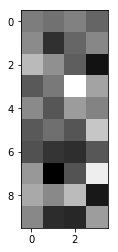

In [271]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)

#generated_image
plt.imshow(generated_image[0, :10, :, 0], cmap='gray')

In [272]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape = [1000,4,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) #predicts the 6 outputs???
    
    return model
    
    

In [273]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

print(decision)

tf.Tensor([[-0.00010447]], shape=(1, 1), dtype=float32)


In [258]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [30]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [32]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [103]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 100

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [34]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [35]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print("STARTING EPOCH")
        start = time.time()
        
        i = 0
        for image_batch in dataset:
            train_step(image_batch)
            print('BATCH', i)
            i = i + 1

        #Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [105]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5,20))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 20, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
    return predictions

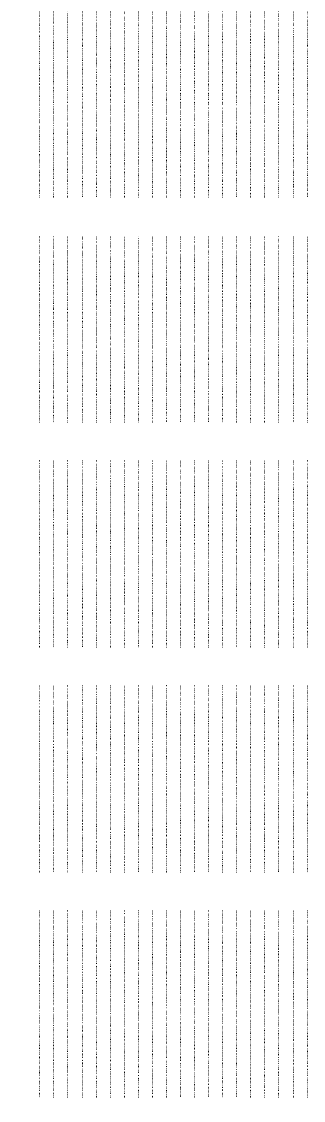

In [374]:
train(train_dataset, EPOCHS)

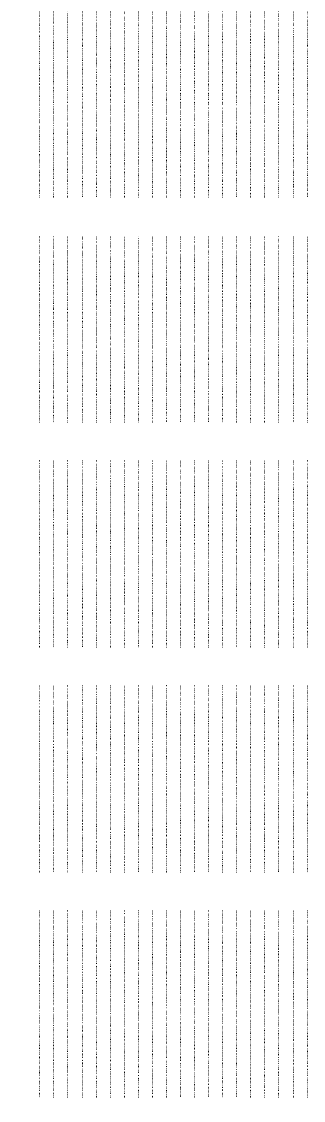

(100, 1000, 4, 1)

In [375]:
class_3 = generate_and_save_images(generator, 20, seed)
class_3.numpy().shape

In [376]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [377]:
class_3 = class_3[:,:,:,0]

In [378]:
class_3_temp = np.argmax(class_3, axis = 2)
final_seqs = np.zeros((100,1000,4))

for i in range(class_0_temp.shape[0]):
    final_seqs[i,:,:] = one_hot(class_3_temp[i,:],4)

np.save("class_3_seqs_v2.npy", final_seqs)


ValueError: num must be 1 <= num <= 8, not 9

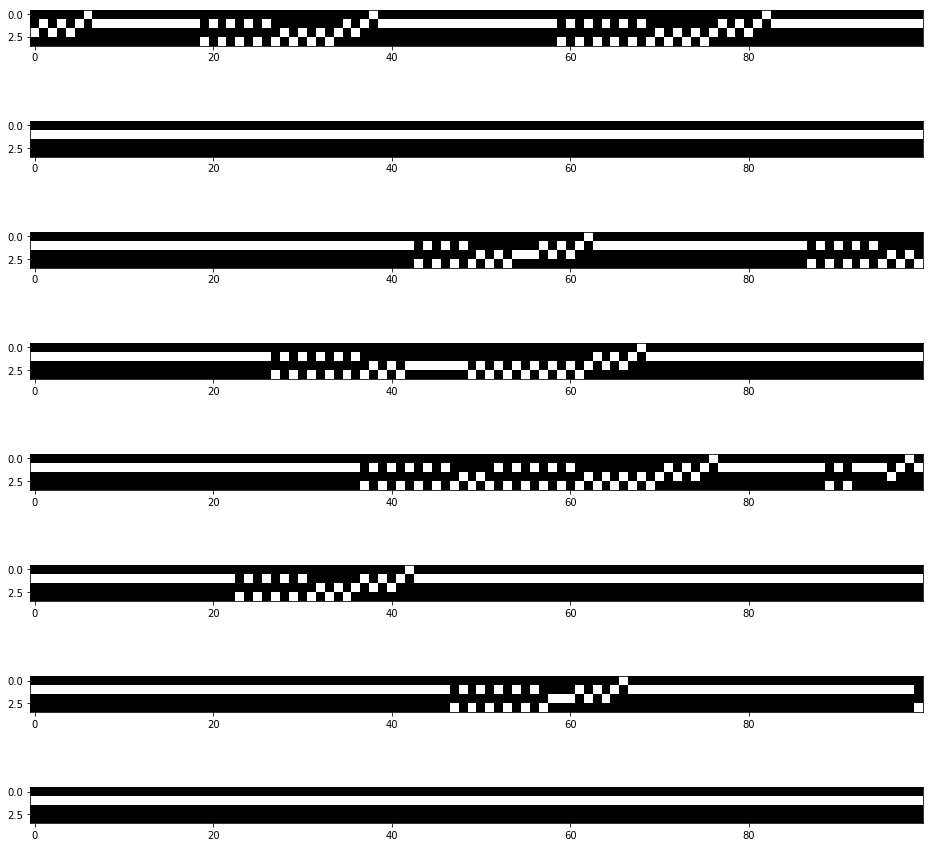

In [51]:
import numpy as np
a = np.load("class_3_seqs_v2.npy", allow_pickle=True)
b = centered_genes[:,:,:,0]

In [52]:
identical = 0

for i in range(a.shape[0]):
    print(i)
    for j in range(b.shape[0]): 
        if (np.array_equal(a[i,:,:], b[j,:,:])):
            identical = identical + 1
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [53]:
identical

0

In [26]:
b.shape

(11208, 1000, 4)